# Trajectory dataset preparation

This notebook contains some data-wrangling codes. The goal is to extract from the dataset, trajectories under suitable forms to perform FPCA and distribution learning.

# Preambles

In [58]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
# sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seig import eig as eig

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data from Pickled file

To restore variables, run this code:

In [59]:
import pickle

with open('prepare_trajectories.pkl', 'rb') as handle:
    pkl_obj = pickle.load(handle)
    container_t_np = pkl_obj['t']
    container_x_np = pkl_obj['x']
    container_y_np = pkl_obj['y']
    print('Data loaded from file')

num_of_trajs = container_y_np.shape[0]

Data loaded from file


# Global FPCA decomposition for Y component

In [60]:
import sklearn
import skfda

%matplotlib inline

Convert the data to appropriate type for the skfda package

In [61]:
fdgrx = skfda.FDataGrid(container_x_np, np.arange(container_x_np.shape[1]))
fdgry = skfda.FDataGrid(container_y_np, np.arange(container_y_np.shape[1]))
# here we don't use the container_t_np vector since we don't want it to mess up the unit

In [62]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

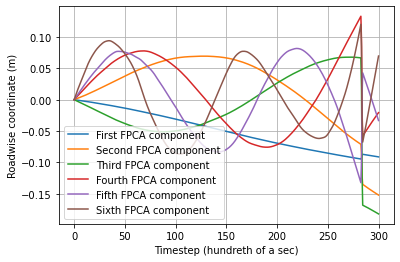

In [63]:
fpca_y = FPCA(n_components=6)
fpca_y.fit(fdgry)
fpca_y.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')

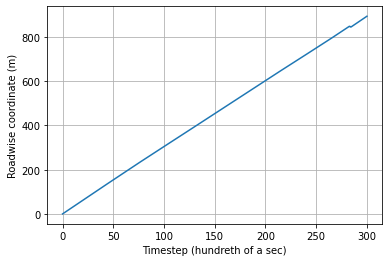

In [64]:
fpca_y.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_y = fpca_y.mean_.data_matrix.reshape((-1))

[8.97315135e-01 7.34864794e-02 2.26640572e-02 5.32613326e-03
 7.12056817e-04 2.99898219e-04]


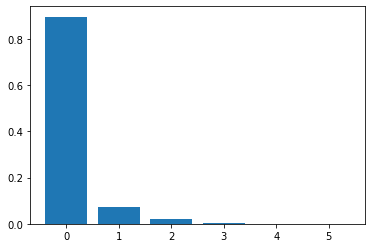

In [65]:
plt.bar(np.arange(6), fpca_y.explained_variance_ratio_)
print(fpca_y.explained_variance_ratio_)

# Global FPCA decomposition for X component

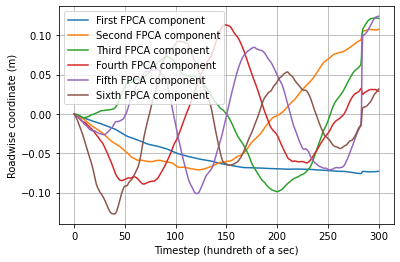

In [66]:
fpca_x = FPCA(n_components=6)
fpca_x.fit(fdgrx)
fpca_x.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')

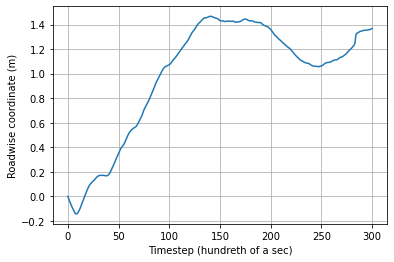

In [67]:
fpca_x.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_x = fpca_x.mean_.data_matrix.reshape((-1))

[0.91929363 0.04625759 0.01301754 0.00650374 0.00424595 0.00248269]


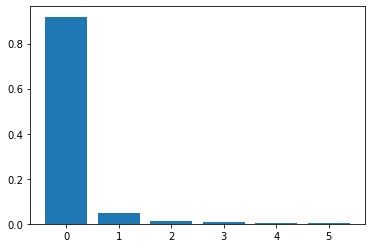

In [68]:
plt.bar(np.arange(6), fpca_x.explained_variance_ratio_)
print(fpca_x.explained_variance_ratio_)

# Get the representations

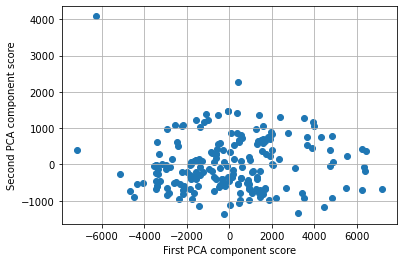

In [69]:
y_basis = fpca_y.components_.data_matrix.squeeze().transpose()
y_coeffs = np.matmul(container_y_np - mean_y, y_basis)
plt.scatter(y_coeffs[:,0], y_coeffs[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

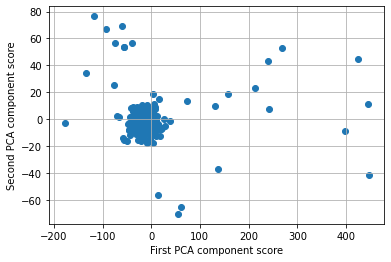

In [70]:
x_basis = fpca_x.components_.data_matrix.squeeze().transpose()
x_coeffs = np.matmul(container_x_np - mean_x, x_basis)
plt.scatter(x_coeffs[:,0], x_coeffs[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

# Zero-meaned trajectories

This might be helpful in analytically finding the basis for the trajectory (which we are suspicious that it is a Fourier basis).

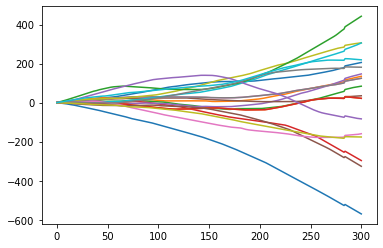

In [71]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y
    plt.plot(traj_to_plot)

(-5.0, 5.0)

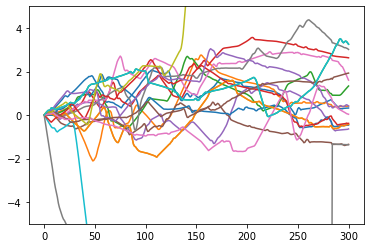

In [72]:

for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_x_np[i] - mean_x
    plt.plot(traj_to_plot)
plt.ylim((-5,5))

# Y trajectories: contribution by PCA component

Original trajectories:

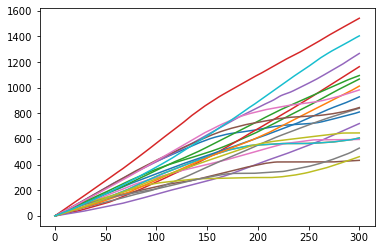

In [73]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i]
    plt.plot(traj_to_plot)

Mean removed:

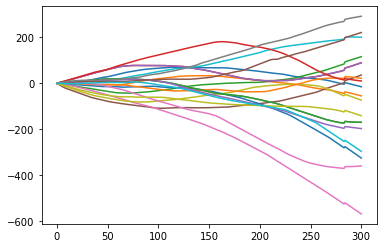

In [74]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y
    plt.plot(traj_to_plot)

Mean and 1st removed:

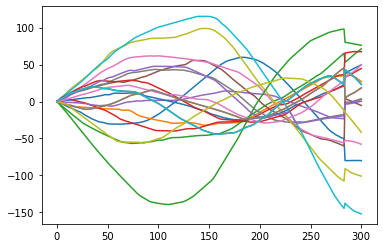

In [75]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y - y_coeffs[i,0] * y_basis[:,0]
    plt.plot(traj_to_plot)

Mean, 1st and 2nd removed

(-40.0, 40.0)

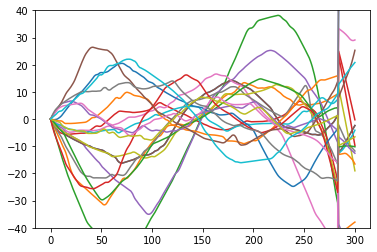

In [76]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y - y_coeffs[i,0] * y_basis[:,0] - y_coeffs[i,1] * y_basis[:,1]
    plt.plot(traj_to_plot)
plt.ylim((-40,40))

# Covariance matrix

In [77]:
y_cov = fdgry.cov().data_matrix[0,:270,:270,0]

(0.0, 269.0, 0.0, 269.0)

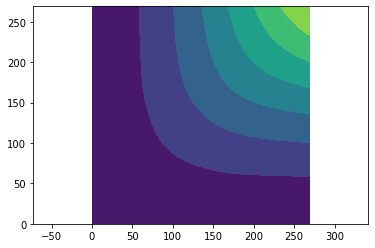

In [78]:
plt.contourf(y_cov)
plt.axis('equal')

# $Cov(X_t, X_t)$

The diagonal of the covariance matrix:

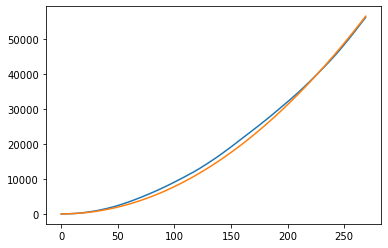

In [79]:
y_cov_diag = np.zeros((270,))
for i in range(270):
    y_cov_diag[i] = y_cov[i,i]
plt.plot(y_cov_diag)
plt.plot(np.arange(270)*np.arange(270)*0.78)

So the covariance matrix seems to grow "exponentially". To check, let's plot out the log:

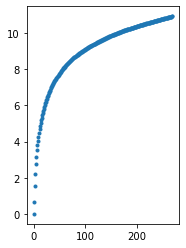

In [80]:
plt.subplot(1,2,1)
y_cov_diag_lg = np.zeros((270,))
for i in range(270):
    y_cov_diag_lg[i] = np.log(y_cov[i,i]+1)
plt.plot(y_cov_diag_lg, '.')

 <ipython-input-81-38c63ed5c23b>:1: RuntimeWarning:divide by zero encountered in log


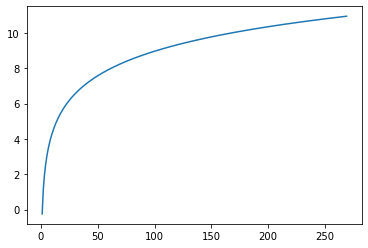

In [81]:
plt.plot(np.log(np.arange(270)*np.arange(270)*0.78))

So the variance, after waiting for a while, grows exponentially (i.e., the log increases linearly), which indicates convergence to a Markov process.

Tendency to convergence is observed, although it's not quite sure whether it's convergence or not. Let's check the first numerical derivative to be sure:

First derivative:

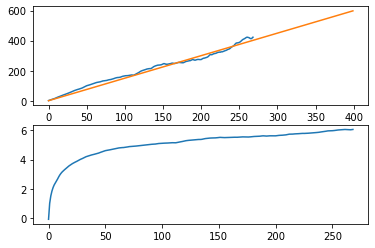

In [82]:

plt.subplot(2,1,1)
plt.plot(np.diff(y_cov_diag))
plt.plot(np.arange(400)*1.5)
plt.subplot(2,1,2)
plt.plot(np.log(np.diff(y_cov_diag)))

Second derivative:

 <ipython-input-83-81b167114649>:4: RuntimeWarning:invalid value encountered in log


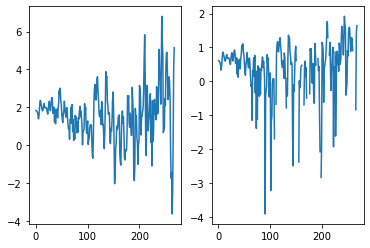

In [83]:
plt.subplot(1,2,1)
plt.plot(np.diff(np.diff(y_cov_diag)))
plt.subplot(1,2,2)
plt.plot(np.log(np.diff(np.diff(y_cov_diag))))

# $Cov(X_{270},X_t)$

Fixing a timestep, say $t=270$, we find $Cov(X_{270}, X_t)$:

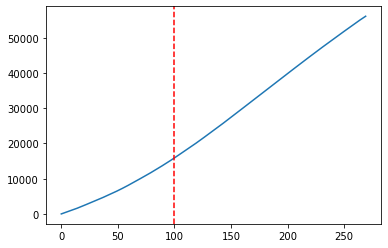

In [84]:
y_cov_100 = np.zeros((270,))
for i in range(270):
    y_cov_100[i] = y_cov[269,i]
plt.plot(y_cov_100)
plt.axvline(x=100, color='r', linestyle='--')

In log graph:

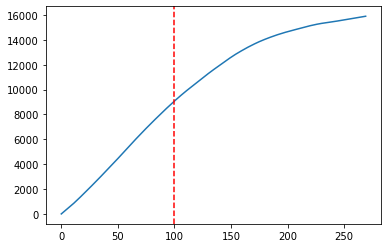

In [85]:
y_cov_100 = np.zeros((270,))
for i in range(270):
    y_cov_100[i] = y_cov[100,i]
plt.plot(y_cov_100)
plt.axvline(x=100, color='r', linestyle='--')

First derivative:

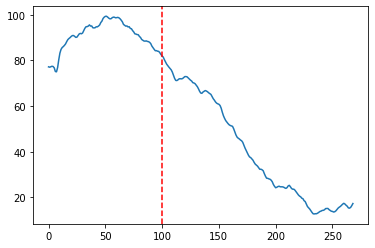

In [86]:
plt.plot(np.diff(y_cov_100))
plt.axvline(x=100, color='r', linestyle='--')

Second derivative:

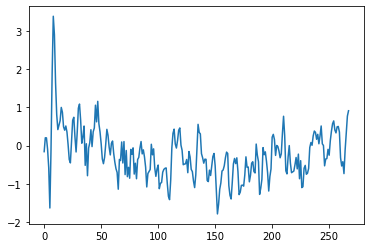

In [87]:
plt.plot(np.diff(np.diff(y_cov_100)))


# First derivative of the trajectory

If the model is to be believed, then we would expect a Wiener process.

(-3.0, 3.0)

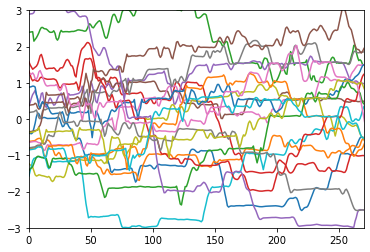

In [88]:
for i in np.random.choice(num_of_trajs, 20):
    plt.plot(np.diff(container_y_np[i] - mean_y))
plt.xlim((0,270))
plt.ylim((-3,3))

(0.0, 269.0, 0.0, 269.0)

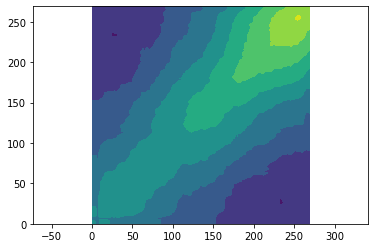

In [89]:
fdgrv = skfda.FDataGrid(np.diff(container_y_np - mean_y), np.arange(container_y_np.shape[1]-1))
cov_mtrxv = fdgrv.cov().data_matrix[0,:270,:270,0]
plt.contourf(cov_mtrxv)
plt.axis('equal')

Is this close to a Wiener process? Check out the second derivative:

(-0.5, 0.5)

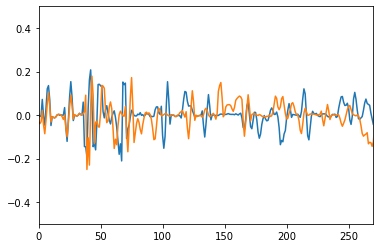

In [90]:
for i in np.random.choice(num_of_trajs, 2):
    plt.plot(np.diff(np.diff(container_y_np[i] - mean_y)))
plt.xlim((0,270))
plt.ylim((-0.5,0.5))

Looks like could be approximated by a Gaussian white noise?